# CS156 (Introduction to AI), Spring 2021
# <u>Homework 10 submission </u>

## Roster Name: Azael Zamora
## Student ID: 013528931
## Email address: azael.zamora@sjsu.edu

# <u>References and sources</u>

* Autoencoders.MNIST.ipynb

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import skimage.io as io
import tensorflow as tf
from tensorflow import keras

In [2]:
np.random.seed(42)

# Load and prepare data

In [3]:
(x_train_valid, y_train_valid), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [4]:
x_train, x_validation, y_train, y_validation = train_test_split(x_train_valid, y_train_valid, test_size = 0.2)

# scale images
x_train = x_train.astype("float32") / 255
x_validation = x_validation.astype("float32") / 255
x_test = x_test.astype("float32") / 255

x_train.shape, x_validation.shape, x_test.shape

((48000, 28, 28), (12000, 28, 28), (10000, 28, 28))

# Part 1

In [5]:
x_train = x_train.reshape(-1, 784)
x_validation = x_validation.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

x_train.shape, x_validation.shape, x_test.shape

((48000, 784), (12000, 784), (10000, 784))

## Creating the autoencoder model

In [6]:
input_layer = keras.Input(shape = (784,))

encoded = keras.layers.Dense(128, activation = 'relu')(input_layer)
encoded = keras.layers.Dense(64, activation = 'relu')(encoded)
encoded = keras.layers.Dense(32, activation = 'relu')(encoded)

decoded = keras.layers.Dense(64, activation = 'relu')(encoded)
decoded = keras.layers.Dense(128, activation = 'relu')(decoded)
decoded = keras.layers.Dense(784, activation = 'sigmoid')(decoded)

# reconstruction model:
autoencoder = keras.Model(input_layer, decoded)


# encoder model:
# encoder = keras.Model(input_layer, encoded)

# decoder model:
#encoded_input = keras.Input(shape = (32,))
#decoder_layer = autoencoder.layers[-3]
#decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

In [7]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_5 (Dense)              (None, 784)               101136

## Training the autoencoder

In [8]:
tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = '/tmp/autoencoder',
                                                 histogram_freq = 1,
                                                 profile_batch = '500, 520')

In [9]:
autoencoder.compile(optimizer = 'adam', loss = 'binary_crossentropy')
autoencoder.fit(x_train, x_train,
                epochs = 30,
                batch_size = 2048,
                shuffle = True,
                validation_data = (x_validation, x_validation),
                callbacks = [tboard_callback])

Epoch 1/30
24/24 [==============================] - 2s 64ms/step - loss: 0.6461 - val_loss: 0.4797
Epoch 2/30
24/24 [==============================] - 1s 42ms/step - loss: 0.4539 - val_loss: 0.3980
Epoch 3/30
24/24 [==============================] - 1s 42ms/step - loss: 0.3888 - val_loss: 0.3669
Epoch 4/30
24/24 [==============================] - 1s 39ms/step - loss: 0.3626 - val_loss: 0.3474
Epoch 5/30
24/24 [==============================] - 1s 39ms/step - loss: 0.3428 - val_loss: 0.3309
Epoch 6/30
24/24 [==============================] - 1s 39ms/step - loss: 0.3293 - val_loss: 0.3223
Epoch 7/30
24/24 [==============================] - 1s 39ms/step - loss: 0.3204 - val_loss: 0.3178
Epoch 8/30
24/24 [==============================] - 1s 39ms/step - loss: 0.3161 - val_loss: 0.3153
Epoch 9/30
24/24 [==============================] - 1s 39ms/step - loss: 0.3140 - val_loss: 0.3120
Epoch 10/30
24/24 [==============================] - 1s 39ms/step - loss: 0.3112 - val_loss: 0.3115
Epoch 11/

In [11]:
# Loading TensorBoard notebook extension.
%load_ext tensorboard
%tensorboard --logdir=/tmp/autoencoder

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 3383), started 0:07:15 ago. (Use '!kill 3383' to kill it.)

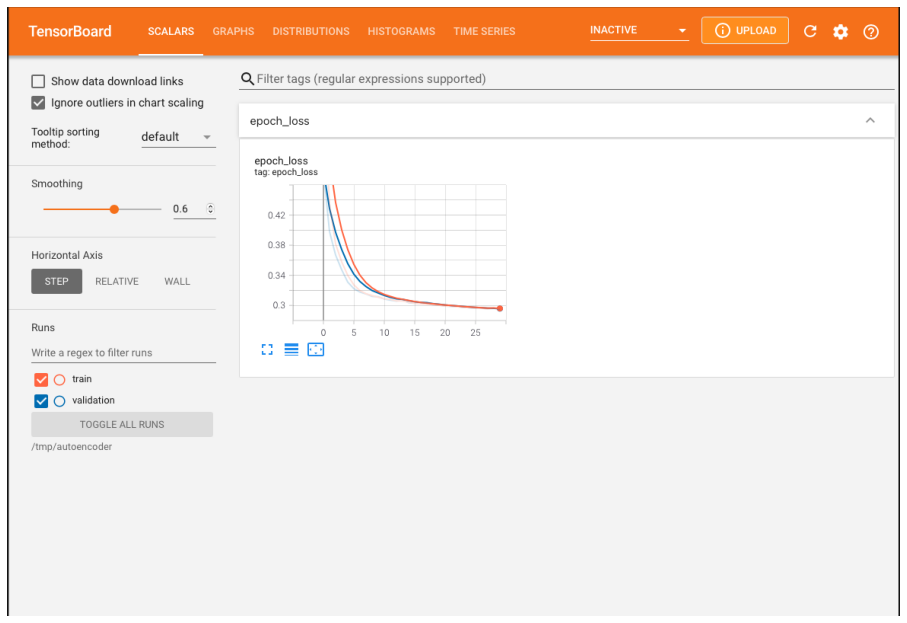

In [12]:
# in case the tensorboard doesnt show
imgBoard = io.imread('tensorboard_hw10.png')
plt.figure(figsize=(16, 16))
plt.axis("off")
plt.imshow(imgBoard)

## Plotting the first 10 images in the test set

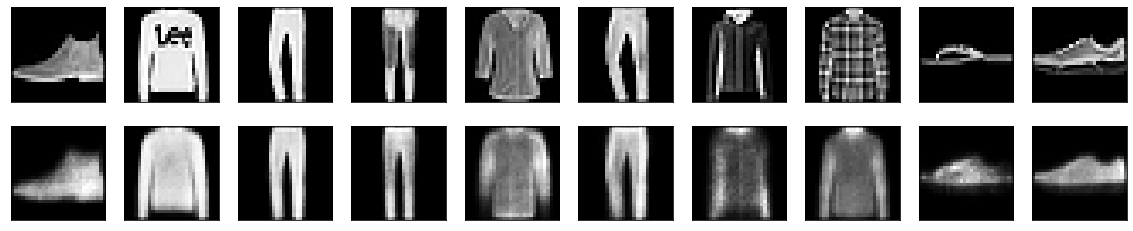

In [13]:
predictions = autoencoder.predict(x_test)

n = 10 # to plot the first 10 images in the test set

plt.figure(figsize = (20, 4))

for i in range(n):
    # original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # reconstructed image
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predictions[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# Part 2, Image denoising with autoencoders

## reshape datasets into image matrices

In [14]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_validation = x_validation.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

x_train.shape, x_validation.shape, x_test.shape

((48000, 28, 28, 1), (12000, 28, 28, 1), (10000, 28, 28, 1))

In [15]:
noise_factor = 0.4

x_train_noise = x_train + noise_factor * np.random.normal(loc = 0.0, scale = 1.0, size = x_train.shape)
x_validation_noise = x_validation + noise_factor * np.random.normal(loc = 0.0, scale = 1.0, size = x_validation.shape)
x_test_noise = x_test + noise_factor + noise_factor * np.random.normal(loc = 0.0, scale = 1.0, size = x_test.shape)

x_train_noise = np.clip(x_train_noise, 0., 1.)
x_validation_noise = np.clip(x_validation_noise, 0., 1.)
x_test_noise = np.clip(x_test_noise, 0., 1.)

## creating the autoencoder model

In [16]:
input_layer = keras.Input(shape = (28, 28, 1))

encode = keras.layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(input_layer)
encode = keras.layers.MaxPooling2D((2, 2), padding = 'same')(encode)
encode = keras.layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(encode)
encoded = keras.layers.MaxPooling2D((2, 2), padding = 'same')(encode)

decode = keras.layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(encoded)
decode = keras.layers.UpSampling2D((2, 2))(decode)
decode = keras.layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(decode)
decode = keras.layers.UpSampling2D((2, 2))(decode)
decoded = keras.layers.Conv2D(1, (3, 3), activation = 'sigmoid', padding = 'same')(decode)

autoencoder = keras.Model(input_layer, decoded)

In [17]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 32)        0   

## Training the encoder

In [18]:
autoencoder.compile(optimizer = 'adam', loss = 'binary_crossentropy')
autoencoder.fit(x_train_noise, x_train_noise,
                epochs = 30,
                batch_size = 2048,
                shuffle = True,
                validation_data = (x_validation_noise, x_validation_noise))

Epoch 1/30
24/24 [==============================] - 31s 1s/step - loss: 0.6385 - val_loss: 0.5525
Epoch 2/30
24/24 [==============================] - 46s 2s/step - loss: 0.5493 - val_loss: 0.5406
Epoch 3/30
24/24 [==============================] - 38s 2s/step - loss: 0.5391 - val_loss: 0.5345
Epoch 4/30
24/24 [==============================] - 40s 2s/step - loss: 0.5338 - val_loss: 0.5310
Epoch 5/30
24/24 [==============================] - 34s 1s/step - loss: 0.5300 - val_loss: 0.5274
Epoch 6/30
24/24 [==============================] - 34s 1s/step - loss: 0.5267 - val_loss: 0.5244
Epoch 7/30
24/24 [==============================] - 35s 1s/step - loss: 0.5239 - val_loss: 0.5221
Epoch 8/30
24/24 [==============================] - 33s 1s/step - loss: 0.5212 - val_loss: 0.5199
Epoch 9/30
24/24 [==============================] - 32s 1s/step - loss: 0.5193 - val_loss: 0.5180
Epoch 10/30
24/24 [==============================] - 32s 1s/step - loss: 0.5175 - val_loss: 0.5172
Epoch 11/30
24/24 [

## Plotting the first 10 images in the test set

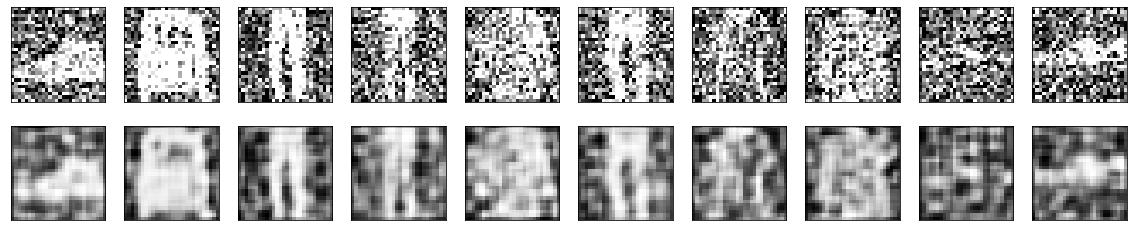

In [19]:
predictions = autoencoder.predict(x_test_noise)

n = 10 # to plot the first 10 images in the test set

plt.figure(figsize = (20, 4))

for i in range(n):
    # original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noise[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # reconstructed image
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predictions[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()